Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(PiecewiseConstantHistory)
help(JointHistory)
help(SFS)
```

In [1]:
%matplotlib notebook
import mushi
from mushi import History, kSFS
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

### Time grid

In [2]:
t = np.logspace(0, 4, 200)

### Demographic history $\eta(t)$

<IPython.core.display.Javascript object>


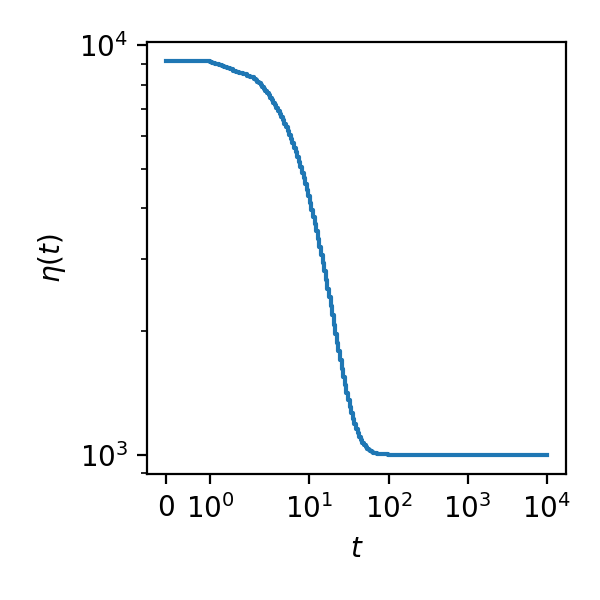

In [3]:
y = 1000 * np.ones(len(t) + 1)
y[:-1] += 9000 * np.exp(- .1 * t)
η = History(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.xlabel('$t$')
plt.ylabel('$η(t)$')
plt.xscale('symlog')
plt.yscale('log')
plt.tight_layout()
plt.show()

### Mutation rate history $\mu(t)$

<IPython.core.display.Javascript object>


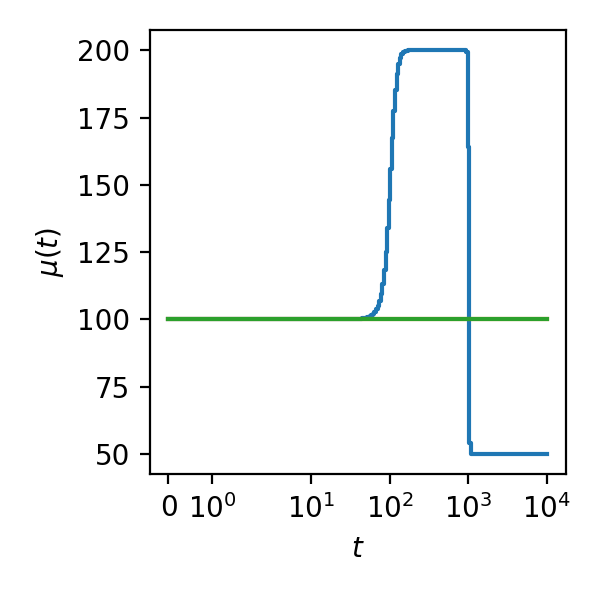

In [4]:
Z = np.ones((len(t) + 1, 3))
Z[1:, 0] += expit(.1 * (t - 100)) - 1.5 * expit(.1 * (t - 1000))
# z[:-1] += 1 * np.exp(- .1 * t)
μ = History(t, 100 * Z)

plt.figure(figsize=(3, 3))
μ.plot()
plt.xlabel('$t$')
plt.ylabel('$μ(t)$')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Simulate a SFS under this history
We'll sample 200 haplotypes, plot the SFS and the CDF of the TMRCA of the sample

<IPython.core.display.Javascript object>


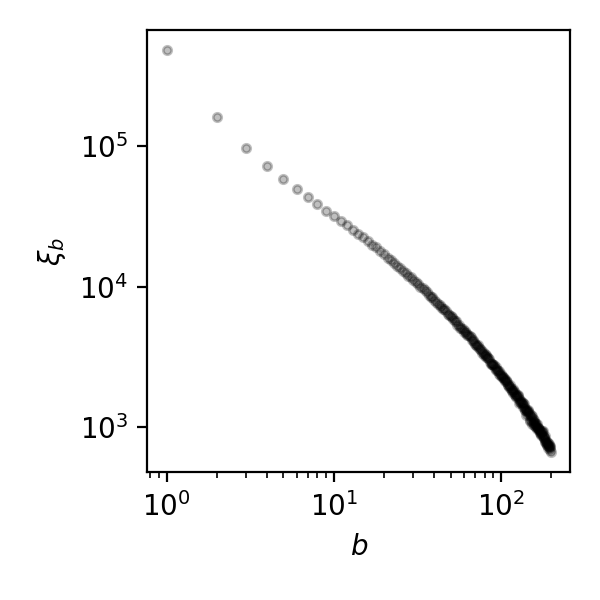

In [5]:
n = 200
sfs = kSFS(η, n=n)
sfs.simulate(μ, seed=1)

plt.figure(figsize=(3, 3))
sfs.plot(0)
plt.tight_layout()
plt.show()

### TMRCA CDF

<IPython.core.display.Javascript object>


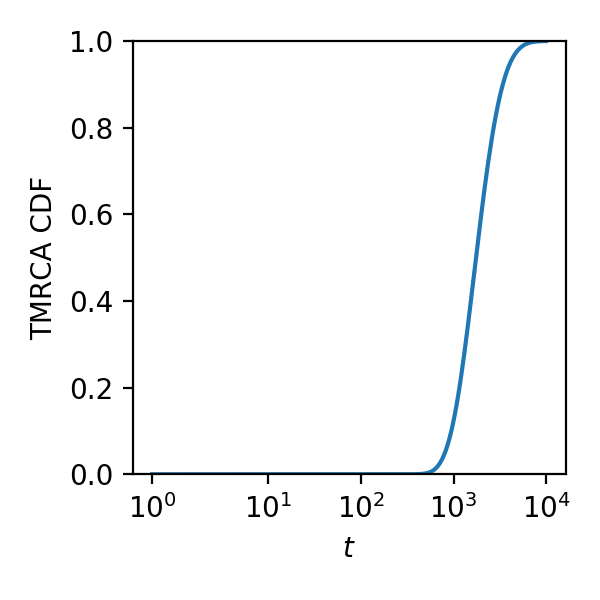

In [6]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, sfs.tmrca_cdf())
plt.xlabel('$t$'); plt.ylabel('TMRCA CDF'); plt.ylim([0, 1]); plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Invert the SFS conditioned on $\eta(t)$ to get $\mu(t)$

In [13]:
λ = 1e0
α = 0.99
s = 1e-1
steps = 20000
bins = None
# bins = np.logspace(0, np.log10(n), 5)
μ_inferred = sfs.infer_μ(λ=λ, α=α, s=s, steps=steps, bins=bins)

<IPython.core.display.Javascript object>


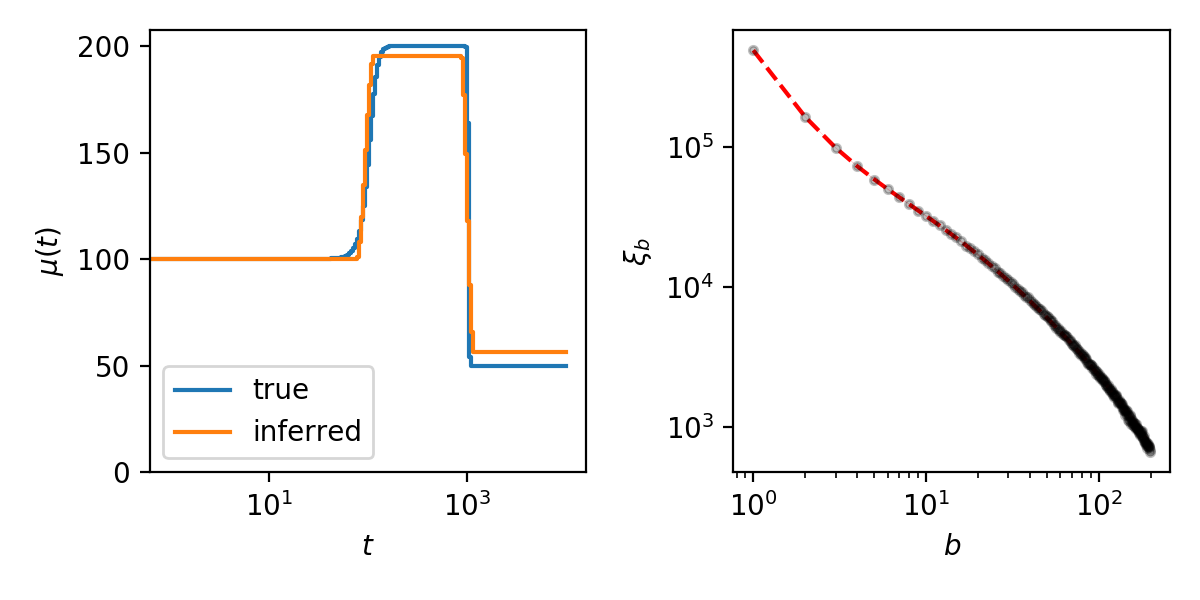

<IPython.core.display.Javascript object>


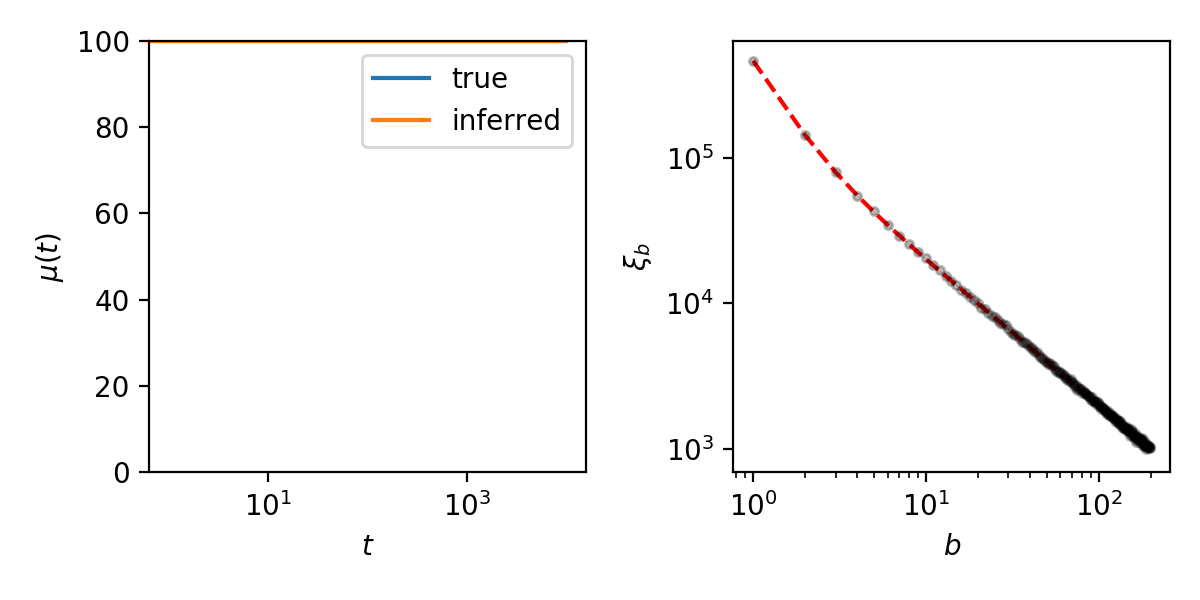

<IPython.core.display.Javascript object>


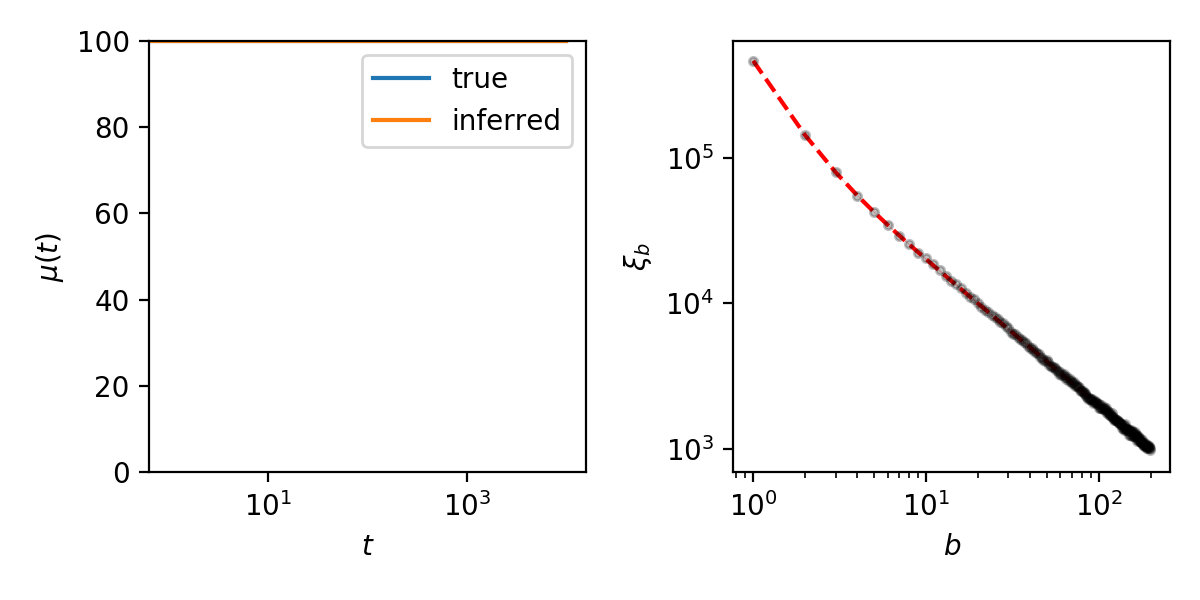

In [14]:
for i in range(Z.shape[1]):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    μ.plot(i, label='true')
    μ_inferred.plot(i, label='inferred')
    plt.xlabel('$t$')
    plt.ylabel('$μ(t)$')
    plt.xscale('log')
    plt.ylim((0, None))

    plt.subplot(1, 2, 2)
    sfs.plot(i, μ=μ_inferred, prf_quantiles=True)
    plt.tight_layout()
    plt.show()